In [ ]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
from typing import List, Set, Dict, Tuple, Optional
from sklearn.preprocessing import StandardScaler
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering
from sklearn.feature_selection import mutual_info_classif
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import FunctionTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
import xgboost as xgb
import lightgbm as lgb
import time
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from sklearn.preprocessing import OrdinalEncoder
from sklearn.dummy import DummyRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor












**Introduction:**

This analysis aims to develop a predictive model to determine the loan grade for loan applications on Lending Club. By leveraging historical loan data and machine learning techniques, the goal is to improve creditworthiness assessment and provide valuable insights to lending institutions for more informed lending decisions.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
grading=pd.read_csv("/content/drive/MyDrive/accepted_2007_to_2018Q4.csv.gz",low_memory=False)

**Basic Checks**

In [ ]:
grading.shape

(2260701, 151)

In [ ]:
features_to_drop = [
    "id",
    "funded_amnt",
    "funded_amnt_inv",
    "installment",
    "pymnt_plan",
    "emp_title",
    "title",
    "url",
    "zip_code",
    "delinq_2yrs",
    "revol_bal",
    "next_pymnt_d",
    "initial_list_status",
    "out_prncp",
    "out_prncp_inv",
    "total_pymnt",
    "total_pymnt_inv",
    "total_rec_prncp",
    "total_rec_int",
    "total_rec_late_fee",
    "recoveries",
    "collection_recovery_fee",
    "last_pymnt_d",
    "last_pymnt_amnt",
    "last_credit_pull_d",
    "last_fico_range_high",
    "last_fico_range_low",
    "collections_12_mths_ex_med",
    "collection_recovery_fee",
    "policy_code",
    "acc_now_delinq",
    "chargeoff_within_12_mths",
    "delinq_amnt",
    "loan_status",
    "tax_liens",
    "hardship_flag",
    "disbursement_method",
    "debt_settlement_flag",
    "member_id",
    "orig_projected_additional_accrued_interest",
    "hardship_dpd",
    "hardship_status",
    "deferral_term",
    "hardship_amount",
    "hardship_start_date",
    "hardship_end_date",
    "payment_plan_start_date",
    "hardship_length",
    "hardship_loan_status",
    "hardship_type"

]

grading = grading.drop(columns=features_to_drop)


In [ ]:
grading.shape

(2260701, 102)

In [ ]:
grading.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2260701 entries, 0 to 2260700
Columns: 102 entries, loan_amnt to settlement_term
dtypes: float64(84), object(18)
memory usage: 1.7+ GB


In [ ]:
grade = grading.groupby("grade").apply(lambda x: x.sample(n=min(100000//len(grading['grade'].unique()), len(x)), random_state=41)).reset_index(drop=True)


In [ ]:
grade.shape

(87168, 102)

In [ ]:
null_counts = grade.isnull().sum()
print(null_counts)

loan_amnt                                  0
term                                       0
int_rate                                   0
grade                                      0
sub_grade                                  0
emp_length                              5477
home_ownership                             0
annual_inc                                 0
verification_status                        0
issue_d                                    0
desc                                   81675
purpose                                    0
addr_state                                 0
dti                                       68
earliest_cr_line                           0
fico_range_low                             0
fico_range_high                            0
inq_last_6mths                             0
mths_since_last_delinq                 43342
mths_since_last_record                 72529
open_acc                                   0
pub_rec                                    0
revol_util

There are so many missing values

In [ ]:
grade = grade.drop(grade[grade["application_type"] == "Joint App"].index)

In [ ]:
grade["application_type"].unique()

array(['Individual'], dtype=object)

In [ ]:
threshold = 48000
null_counts = grade.isnull().sum()
columns_to_drop = null_counts[null_counts > threshold].index
grade.drop(columns=columns_to_drop, inplace=True)

In [ ]:
grade.shape

(82525, 72)

In [ ]:
threshold = 35000
grade= grade.dropna(thresh=len(grade) - threshold, axis=1)



In [ ]:
# Fill missing values in numeric columns with the mean
numeric_columns = ['emp_length', 'revol_util', 'tot_coll_amt', 'tot_cur_bal', 'total_rev_hi_lim', 'acc_open_past_24mths', 'avg_cur_bal', 'bc_open_to_buy', 'bc_util', 'mo_sin_old_il_acct', 'mo_sin_old_rev_tl_op', 'mo_sin_rcnt_rev_tl_op', 'mo_sin_rcnt_tl', 'mort_acc', 'mths_since_recent_bc', 'mths_since_recent_inq', 'num_accts_ever_120_pd', 'num_actv_bc_tl', 'num_actv_rev_tl', 'num_bc_sats', 'num_bc_tl', 'num_il_tl', 'num_op_rev_tl', 'num_rev_accts', 'num_rev_tl_bal_gt_0', 'num_sats', 'num_tl_120dpd_2m', 'num_tl_30dpd', 'num_tl_90g_dpd_24m', 'num_tl_op_past_12m', 'pct_tl_nvr_dlq', 'percent_bc_gt_75', 'pub_rec_bankruptcies', 'tot_hi_cred_lim', 'total_bal_ex_mort', 'total_bc_limit', 'total_il_high_credit_limit']
grade[numeric_columns] = grade[numeric_columns].fillna(grade[numeric_columns].mean())

# Fill missing values in categorical columns with the mode
categorical_columns = ['emp_length']
grade[categorical_columns] = grade[categorical_columns].fillna(grade[categorical_columns].mode().iloc[0])


<ipython-input-16-4910ed3923cb>:3: FutureWarning: The default value of numeric_only in DataFrame.mean is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  grade[numeric_columns] = grade[numeric_columns].fillna(grade[numeric_columns].mean())


In [ ]:
grade.isna().sum()

loan_amnt                     0
term                          0
int_rate                      0
grade                         0
sub_grade                     0
emp_length                    0
home_ownership                0
annual_inc                    0
verification_status           0
issue_d                       0
purpose                       0
addr_state                    0
dti                           0
earliest_cr_line              0
fico_range_low                0
fico_range_high               0
inq_last_6mths                0
open_acc                      0
pub_rec                       0
revol_util                    0
total_acc                     0
application_type              0
tot_coll_amt                  0
tot_cur_bal                   0
total_rev_hi_lim              0
acc_open_past_24mths          0
avg_cur_bal                   0
bc_open_to_buy                0
bc_util                       0
mo_sin_old_il_acct            0
mo_sin_old_rev_tl_op          0
mo_sin_r

In [ ]:
grade.shape

(82525, 57)

In [ ]:
grade = grade.drop(columns=["sub_grade", "int_rate"])

In [ ]:
grade_mapping = {'A': 0, 'B': 1, 'C': 2, 'D': 3, 'E': 4, 'F': 5, 'G': 6}
# Map the "grade" column using the defined mapping
grade['grade'] = grade['grade'].map(grade_mapping)

In [ ]:
grade['grade'].unique()

array([0, 1, 2, 3, 4, 5, 6])

In [ ]:
correlation_matrix = grade.corr()

<ipython-input-22-c33aa26bf2f7>:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  correlation_matrix = grade.corr()


In [ ]:
num_top_correlated = 20
top_correlated_features = correlation_matrix.nlargest(num_top_correlated, 'grade')['grade'].index


In [ ]:
features = grade.select_dtypes(include='number').columns.tolist()
mi_scores = mutual_info_classif(grade[features], grade['grade'])


In [ ]:
# Select the top M features based on mutual information
num_top_mi = 20
top_mi_features = grade[features].columns[np.argsort(mi_scores)][::-1][:num_top_mi]


In [ ]:
# Combine the top correlated features and top mutual information features
selected_features = list(set(top_correlated_features).union(set(top_mi_features)))


In [ ]:
selected_features


['num_rev_tl_bal_gt_0',
 'fico_range_low',
 'total_bc_limit',
 'num_sats',
 'mths_since_recent_inq',
 'fico_range_high',
 'bc_util',
 'total_rev_hi_lim',
 'num_actv_rev_tl',
 'total_bal_ex_mort',
 'loan_amnt',
 'num_il_tl',
 'num_tl_90g_dpd_24m',
 'tot_hi_cred_lim',
 'pub_rec',
 'open_acc',
 'mo_sin_rcnt_tl',
 'inq_last_6mths',
 'grade',
 'num_accts_ever_120_pd',
 'dti',
 'percent_bc_gt_75',
 'bc_open_to_buy',
 'num_tl_op_past_12m',
 'revol_util',
 'mo_sin_old_rev_tl_op',
 'acc_open_past_24mths',
 'num_actv_bc_tl',
 'mo_sin_rcnt_rev_tl_op',
 'pub_rec_bankruptcies',
 'avg_cur_bal']

In [ ]:
additional_append= ["annual_inc", "emp_length", "purpose", "term", "verification_status","grade","earliest_cr_line","issue_d"]

for col in additional_append:
    if col not in selected_features:
        selected_features.append(col)

In [ ]:
grade = grade[selected_features].copy()

In [ ]:
grade.shape

(82525, 38)

In [ ]:
grade.head()

,num_rev_tl_bal_gt_0,fico_range_low,total_bc_limit,num_sats,mths_since_recent_inq,fico_range_high,bc_util,total_rev_hi_lim,num_actv_rev_tl,total_bal_ex_mort,loan_amnt,num_il_tl,num_tl_90g_dpd_24m,tot_hi_cred_lim,pub_rec,open_acc,mo_sin_rcnt_tl,inq_last_6mths,grade,num_accts_ever_120_pd,dti,percent_bc_gt_75,bc_open_to_buy,num_tl_op_past_12m,revol_util,mo_sin_old_rev_tl_op,acc_open_past_24mths,num_actv_bc_tl,mo_sin_rcnt_rev_tl_op,pub_rec_bankruptcies,avg_cur_bal,annual_inc,emp_length,purpose,term,verification_status,earliest_cr_line,issue_d
0,2.000000,715.0,6000.000000,12.000000,14.000000,719.0,81.800000,9500.000000,2.000000,115835.000000,6000.0,19.00000,0.000000,567695.000000,0.0,12.0,9.000000,0.0,0,2.000000,20.14,100.000000,1089.000000,2.000000,72.3,247.000000,6.000000,1.000000,14.000000,0.0,40010.000000,162000.0,10+ years,other,36 months,Not Verified,Nov-1997,Jun-2018
1,7.000000,710.0,66300.000000,18.000000,17.000000,714.0,63.500000,99800.000000,7.000000,93541.000000,20000.0,9.00000,0.000000,613451.000000,0.0,18.0,10.000000,0.0,0,0.000000,34.86,44.400000,24167.000000,1.000000,61.9,257.000000,3.000000,6.000000,10.000000,0.0,25961.000000,110000.0,2 years,credit_card,36 months,Not Verified,Oct-1996,Mar-2018
2,5.000000,685.0,3000.000000,8.000000,9.000000,689.0,52.400000,9200.000000,5.000000,24050.000000,10000.0,2.00000,0.000000,34168.000000,0.0,8.0,16.000000,0.0,0,0.000000,13.78,0.000000,1428.000000,0.000000,53.1,151.000000,5.000000,2.000000,16.000000,0.0,3006.000000,60000.0,4 years,credit_card,36 months,Not Verified,Sep-2005,May-2018
3,2.000000,755.0,9800.000000,11.000000,6.140808,759.0,15.300000,16300.000000,2.000000,60135.000000,20000.0,8.00000,0.000000,438129.000000,0.0,11.0,5.000000,0.0,0,0.000000,18.57,0.000000,8299.000000,1.000000,38.1,219.000000,2.000000,1.000000,77.000000,0.0,38629.000000,122200.0,10+ years,debt_consolidation,36 months,Not Verified,Jul-1990,Jul-2017
4,5.796921,750.0,20792.373943,11.797993,6.140808,754.0,61.849166,32133.717951,5.846716,52342.265293,7000.0,8.64399,0.093558,167822.196139,0.0,12.0,7.324159,0.0,0,0.534507,15.39,47.574074,9354.768724,2.456735,22.1,173.179885,5.108263,3.732311,12.553271,0.0,12694.035752,90000.0,10+ years,major_purchase,36 months,Not Verified,Dec-1976,Jul-2010



In this analysis, the top 20 features were selected based on their correlation and mutual information with the loan grading feature. These features showed a strong relationship with the target variable and were deemed important for predicting loan grades accurately.

To enhance the modeling process and capture additional relevant information, extra features were appended to the dataset. These additional features were carefully chosen based on their relevance and potential impact on the loan grading prediction.

By incorporating these selected features, the modeling process can benefit from the increased predictive power and provide more accurate loan grade predictions. The combination of highly correlated and mutually informative features, along with the carefully selected additional features, aims to improve the model's ability to assess creditworthiness and make more informed lending decisions.

Overall, this feature selection and augmentation process enhances the predictive modeling capabilities, allowing for a more comprehensive analysis of loan grading factors and increasing the accuracy of loan grade predictions

In [ ]:
grade["emp_length"] = grade["emp_length"].str.replace("+", "")


<ipython-input-32-b285d9d7d966>:1: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  grade["emp_length"] = grade["emp_length"].str.replace("+", "")


In [ ]:
grade["emp_length"].unique()

array(['10 years', '2 years', '4 years', '3 years', '7 years', '9 years',
       '< 1 year', '5 years', '1 year', '6 years', '8 years'],
      dtype=object)

In [ ]:
grade["verification_status"].unique()

array(['Not Verified', 'Source Verified', 'Verified'], dtype=object)

In [ ]:
X = grade.drop(["grade"], axis=1)
y = grade["grade"]


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, stratify=y, random_state=42
)


In [ ]:
def extract_credit_line_year(X: pd.DataFrame) -> pd.DataFrame:
    """
    Extracts the year component from the 'earliest_cr_line' column and adds it as a new column 'credit_line_year'.
    """
    X = X.copy()
    X["credit_line_year"] = pd.DatetimeIndex(X["earliest_cr_line"]).year
    return X



In [ ]:
def extract_issue_and_credit_line_month(X: pd.DataFrame) -> pd.DataFrame:
    """
    Extracts the month component from the 'issue_d' and 'earliest_cr_line' columns and adds them as new columns
    'issue_month' and 'credit_line_month', respectively. Drops the original date columns after extraction.
    """
    X = X.copy()
    X["issue_month"] = pd.DatetimeIndex(X["issue_d"]).month
    X["credit_line_month"] = pd.DatetimeIndex(X["earliest_cr_line"]).month
    X.drop(columns=["issue_d", "earliest_cr_line"], inplace=True)
    return X



In [ ]:
def get_categorical_features(X: pd.DataFrame) -> List[str]:
    categorical_features = X.select_dtypes(include=["object"]).columns.tolist()
    categorical_features = [col for col in categorical_features if col not in ["issue_d", "earliest_cr_line"]]
    return categorical_features



In [ ]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

def evaluate_regressors(regressors, X_train, y_train, X_test, y_test):
    results = []

    for reg_name, reg in regressors:
        start_time = time.time()
        reg.fit(X_train, y_train)
        y_pred = reg.predict(X_test)
        end_time = time.time()
        elapsed_time = round(end_time - start_time, 3)
        mse = round(mean_squared_error(y_test, y_pred), 3)
        rmse = round(mean_squared_error(y_test, y_pred, squared=False), 3)
        mae = round(mean_absolute_error(y_test, y_pred), 3)
        r2 = round(r2_score(y_test, y_pred), 3)
        score = round(reg.score(X_test, y_test), 3)  # Added score calculation
        results.append({
            'Regressor': reg_name,
            'Mean Squared Error': mse,
            'Root Mean Squared Error': rmse,
            'Mean Absolute Error': mae,
            'R2 Score': r2,
            'Score': score,  # Added score in the results
            'Time Taken': elapsed_time
        })

    return pd.DataFrame(results)



In [ ]:
get_categorical_features(X)

['emp_length', 'purpose', 'term', 'verification_status']

In [ ]:
def extract_year(X):
    return pd.DatetimeIndex(X).year

In [ ]:
def extract_month(X):
    return pd.DatetimeIndex(X).month



In [ ]:
def evaluate_classifiers(classifiers, X_train, y_train, X_test, y_test):
    results = []

    for clf_name, clf in classifiers:
        start_time = time.time()
        clf.fit(X_train, y_train)
        y_pred = clf.predict(X_test)
        end_time = time.time()
        elapsed_time = round(end_time - start_time, 3)
        accuracy = round(accuracy_score(y_test, y_pred), 3)
        f1 = round(f1_score(y_test, y_pred, average='weighted'), 3)
        precision = round(precision_score(y_test, y_pred, average='weighted'), 3)
        recall = round(recall_score(y_test, y_pred, average='weighted'), 3)
        results.append({
            'Classifier': clf_name,
            'Accuracy': accuracy,
            'F1 Score': f1,
            'Precision': precision,
            'Recall': recall,
            'Time Taken': elapsed_time
        })

    return pd.DataFrame(results)



In [ ]:
year= FunctionTransformer(extract_credit_line_year, validate=False)
month = FunctionTransformer(extract_issue_and_credit_line_month, validate=False)


In [ ]:
numeric_features = list(X.select_dtypes(include=["float64"]).columns)
numeric_features.extend(["credit_line_year", "issue_month", "credit_line_month"])
categorical_features = get_categorical_features(X)

In [ ]:
f_extr= Pipeline(
    steps=[

        ("year", year),
        ("month", month),
    ]
)


In [ ]:
categorical_transformer= Pipeline(
    steps=[("encoder", OneHotEncoder(sparse=False, handle_unknown="ignore"))]
)

numeric_transformer= Pipeline(
    steps=[
        ("scaler", StandardScaler()),
    ]
)

preprocessor = ColumnTransformer(
    transformers=[
        ("categorical", categorical_transformer, categorical_features),
        ("numeric", numeric_transformer, numeric_features),
    ],
    remainder="passthrough",
)

In [ ]:
pipe_transform = Pipeline(
    steps=[

        ("f_extr", f_extr),
        ("preprocessor", preprocessor),
    ]
)

In [ ]:
classifiers = [
    ("Logistic Regression", LogisticRegression(max_iter=1000)),
    ("Random Forest", RandomForestClassifier()),
    ("AdaBoost", AdaBoostClassifier()),
    ("XGBoost", xgb.XGBClassifier()),
    ("LightGBM", lgb.LGBMClassifier())
]

In [ ]:
X_train_transformed = pipe_transform.fit_transform(X_train)
X_test_transformed = pipe_transform.transform(X_test)


/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


In [ ]:
evaluation_results = evaluate_classifiers(classifiers, X_train_transformed, y_train, X_test_transformed, y_test)
print(evaluation_results)


            Classifier  Accuracy  F1 Score  Precision  Recall  Time Taken
0  Logistic Regression     0.379     0.371      0.367   0.379      28.907
1        Random Forest     0.375     0.365      0.360   0.375      28.236
2             AdaBoost     0.374     0.365      0.361   0.374      12.028
3              XGBoost     0.395     0.388      0.384   0.395     170.796
4             LightGBM     0.401     0.392      0.388   0.401      13.375


In [ ]:
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.1, 0.01, 0.001]
}

# Perform hyperparameter tuning using GridSearchCV
grid_search = GridSearchCV(estimator=lgb.LGBMClassifier(), param_grid=param_grid, cv=3)
grid_search.fit(X_train_transformed, y_train)

# Get the best hyperparameters and the corresponding model
best_params = grid_search.best_params_
best_model = grid_search.best_estimator_


In [ ]:
y_pred = best_model.predict(X_test_transformed)
classification_rep = classification_report(y_test, y_pred)
confusion_mat = confusion_matrix(y_test, y_pred)

# Print the classification report and confusion matrix
print("Classification Report:")
print(classification_rep)
print("\nConfusion Matrix:")
print(confusion_mat)

Classification Report:
              precision    recall  f1-score   support

           0       0.68      0.74      0.71      3554
           1       0.40      0.48      0.43      3558
           2       0.32      0.30      0.31      3523
           3       0.29      0.22      0.25      3542
           4       0.26      0.21      0.23      3575
           5       0.31      0.33      0.32      3569
           6       0.45      0.51      0.48      3437

    accuracy                           0.40     24758
   macro avg       0.39      0.40      0.39     24758
weighted avg       0.39      0.40      0.39     24758


Confusion Matrix:
[[2625  774  114   28   10    3    0]
 [ 848 1695  642  224   95   26   28]
 [ 233 1011 1041  570  364  200  104]
 [ 107  484  730  796  665  502  258]
 [  28  192  418  614  740  968  615]
 [   8   91  224  323  546 1193 1184]
 [   8   43  120  207  379  921 1759]]


In [ ]:
# Calculate the accuracy
accuracy = accuracy_score(y_test, y_pred)

# Print the accuracy
print("Accuracy:", accuracy)

Accuracy: 0.39781080862751433


In [ ]:
categorical_feature_names = list(pipe_transform.named_steps['preprocessor'].transformers_[0][1]['encoder'].get_feature_names_out())
numeric_feature_names = list(pipe_transform.named_steps['preprocessor'].transformers_[1][1].get_feature_names_out())
feature_names = categorical_feature_names + numeric_feature_names

In [ ]:
feature_importances = best_model.feature_importances_

In [ ]:
feature_importance_df = pd.DataFrame({"Feature": feature_names, "Importance": feature_importances})
feature_importance_df = feature_importance_df.sort_values("Importance", ascending=False)

top_10_features = feature_importance_df.head(10)

In [ ]:
top_10_stylized = top_10_features.style.background_gradient(cmap='Blues')
top_10_stylized

,Feature,Importance
40,loan_amnt,2707
49,dti,2243
31,fico_range_low,1843
60,annual_inc,1821
54,mo_sin_old_rev_tl_op,1630
53,revol_util,1495
51,bc_open_to_buy,1422
37,total_rev_hi_lim,1406
43,tot_hi_cred_lim,1366
41,num_il_tl,1295


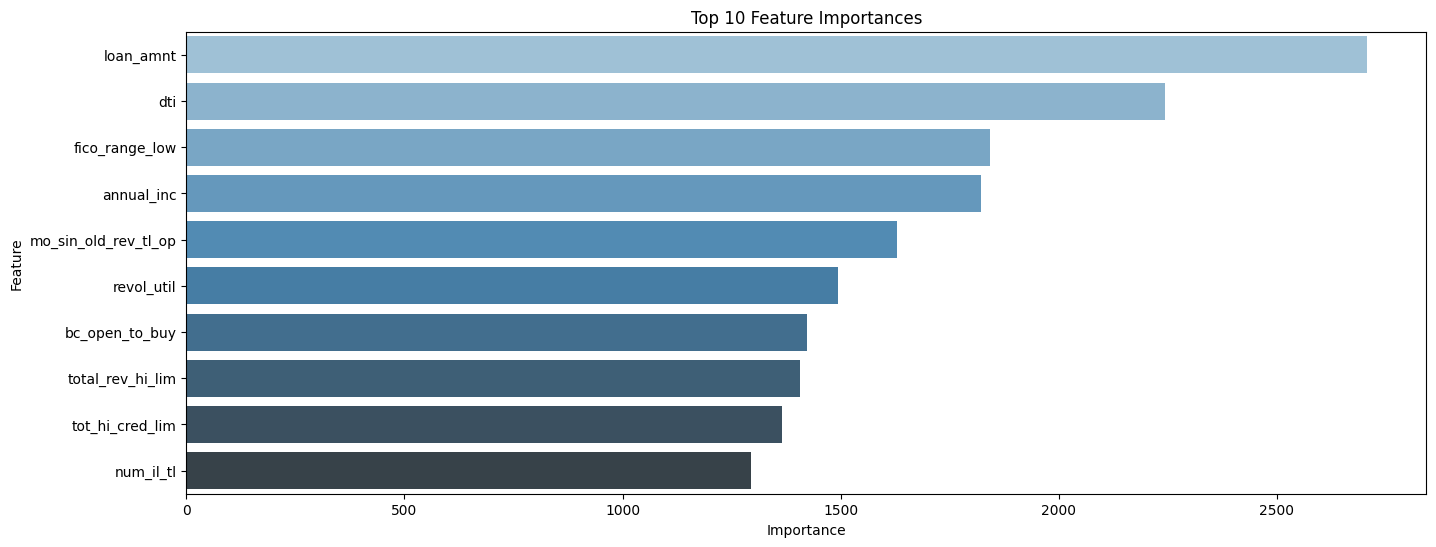

In [ ]:
feature_importances = best_model.feature_importances_
feature_importance_df = pd.DataFrame({"Feature": feature_names, "Importance": feature_importances})

feature_importance_df = feature_importance_df.sort_values("Importance", ascending=False)

top_10_features = feature_importance_df.head(10)


plt.figure(figsize=(16, 6))
sns.barplot(x="Importance", y="Feature", data=top_10_features, palette="Blues_d")
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.title("Top 10 Feature Importances")
plt.show()

In [ ]:
numeric_features = grade.select_dtypes(include=['float64']).columns.tolist()


In [ ]:
subset = grade[numeric_features]

In [ ]:
subset.shape

(82525, 31)

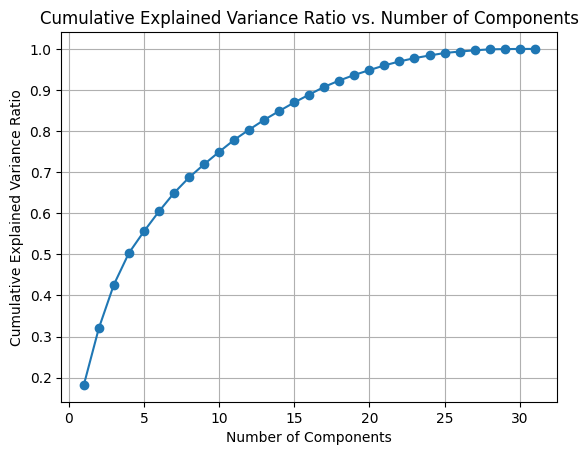

In [ ]:
scaler = StandardScaler()
scaled_features = scaler.fit_transform(subset)

# Create PCA object
pca = PCA()

# Fit PCA on the scaled features
pca.fit(scaled_features)

# Calculate the cumulative explained variance ratio
cumulative_variance = np.cumsum(pca.explained_variance_ratio_)

# Plot the cumulative explained variance ratio
plt.plot(range(1, len(numeric_features) + 1), cumulative_variance, marker='o')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance Ratio')
plt.title('Cumulative Explained Variance Ratio vs. Number of Components')
plt.grid(True)
plt.show()

In [ ]:
cumulative_variance

array([0.18231034, 0.32045679, 0.42643112, 0.50332819, 0.5559314 ,
       0.60461509, 0.64929377, 0.6870931 , 0.71916729, 0.74940033,
       0.77859887, 0.80354039, 0.82733456, 0.84889234, 0.8696945 ,
       0.88893245, 0.9077968 , 0.92313922, 0.93669707, 0.94845058,
       0.95992989, 0.96957402, 0.97759537, 0.98402403, 0.9900332 ,
       0.99360811, 0.9965737 , 0.99897037, 0.99956685, 1.        ,
       1.        ])

In [ ]:
pca = PCA(n_components=10)
principal_components = pca.fit_transform(scaled_features)

print("Explained Variance Ratio:", pca.explained_variance_ratio_)

Explained Variance Ratio: [0.18231034 0.13814646 0.10597433 0.07689706 0.05260318 0.04868369
 0.04467867 0.03779916 0.03207397 0.03023282]


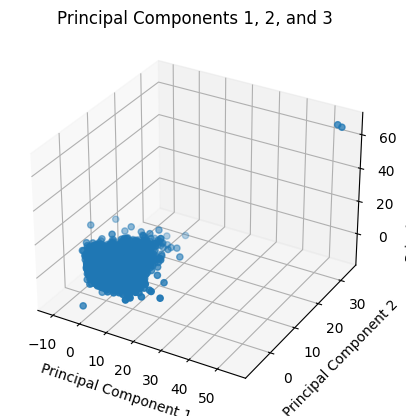

In [ ]:
pc1 = principal_components[:, 0]
pc2 = principal_components[:, 1]
pc3 = principal_components[:, 2]


fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(pc1, pc2, pc3)
ax.set_xlabel('Principal Component 1')
ax.set_ylabel('Principal Component 2')
ax.set_zlabel('Principal Component 3')
ax.set_title('Principal Components 1, 2, and 3')
plt.show()

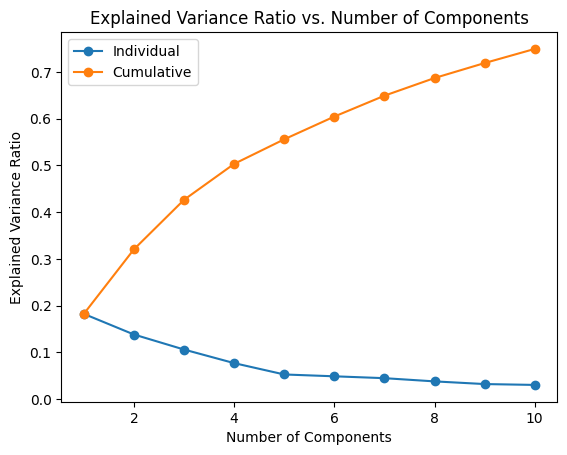

In [ ]:
cumulative_variance = np.cumsum(pca.explained_variance_ratio_)


plt.plot(range(1, len(pca.explained_variance_ratio_) + 1), pca.explained_variance_ratio_, marker='o')
plt.plot(range(1, len(cumulative_variance) + 1), cumulative_variance, marker='o')
plt.xlabel('Number of Components')
plt.ylabel('Explained Variance Ratio')
plt.title('Explained Variance Ratio vs. Number of Components')
plt.legend(['Individual', 'Cumulative'])
plt.show()

In [ ]:
# Apply k-means clustering
kmeans = KMeans(n_clusters=3)
kmeans_labels = kmeans.fit_predict(principal_components)


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


In [ ]:
print("K-Means Labels:", kmeans_labels)

K-Means Labels: [0 2 0 ... 0 0 0]


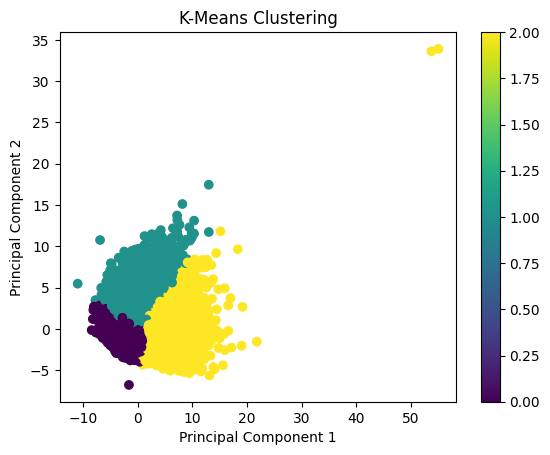

In [ ]:
plt.scatter(principal_components[:, 0], principal_components[:, 1], c=kmeans_labels)
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('K-Means Clustering')
plt.colorbar()
plt.show()


## **Conclusion**

Based on the evaluation results, the best performing classifier for predicting loan grades on the Lending Club dataset is the LightGBM classifier. It achieved an accuracy of 0.401, an F1 score of 0.392, a precision of 0.388, and a recall of 0.401. The classifier took approximately 13.375 seconds to train and predict.

To further optimize the model, hyperparameter tuning was performed using GridSearchCV. The following hyperparameters were tuned: 'n_estimators' (number of boosting iterations), 'max_depth' (maximum depth of a tree), and 'learning_rate' (shrinkage factor for the learning rate). The best hyperparameters found were 'n_estimators': 200, 'max_depth': 5, and 'learning_rate': 0.1.

The best model with the tuned hyperparameters was then evaluated on the test set. The classification report shows the precision, recall, and F1-score for each class, along with the support (number of samples). The confusion matrix provides the counts of true positive, false positive, true negative, and false negative predictions for each class.

Overall, the model achieved an accuracy of 0.40 on the test set, indicating that it can predict loan grades with moderate success. However, there is still room for improvement, as indicated by the relatively low F1 scores for some classes. Further analysis and experimentation may be required to enhance the model's performance.

**Sub_Grade:**

In [ ]:
sub_grade = grading.groupby("sub_grade").apply(lambda x: x.sample(n=min(100000//len(grading["sub_grade"].unique()), len(x)), random_state=41)).reset_index(drop=True)


In [ ]:
sub_grade.shape

(94149, 102)

In [ ]:
null_counts = sub_grade.isnull().sum()
print(null_counts)

loan_amnt                                  0
term                                       0
int_rate                                   0
grade                                      0
sub_grade                                  0
emp_length                              5931
home_ownership                             0
annual_inc                                 1
verification_status                        0
issue_d                                    0
desc                                   88401
purpose                                    0
addr_state                                 0
dti                                       90
earliest_cr_line                           2
fico_range_low                             0
fico_range_high                            0
inq_last_6mths                             2
mths_since_last_delinq                 47070
mths_since_last_record                 78527
open_acc                                   2
pub_rec                                    2
revol_util

In [ ]:
sub_grade = sub_grade.drop(sub_grade[sub_grade["application_type"] == "Joint App"].index)

In [ ]:
sub_grade["application_type"].unique()

array(['Individual'], dtype=object)

In [ ]:
threshold = 48000
null_counts = sub_grade.isnull().sum()
columns_to_drop = null_counts[null_counts > threshold].index
sub_grade.drop(columns=columns_to_drop, inplace=True)

In [ ]:
sub_grade.shape

(89292, 72)

In [ ]:
threshold = 35000
sub_grade= sub_grade.dropna(thresh=len(sub_grade) - threshold, axis=1)


In [ ]:
sub_grade.isna().sum()

loan_amnt                         0
term                              0
int_rate                          0
grade                             0
sub_grade                         0
emp_length                     5250
home_ownership                    0
annual_inc                        1
verification_status               0
issue_d                           0
purpose                           0
addr_state                        0
dti                               0
earliest_cr_line                  2
fico_range_low                    0
fico_range_high                   0
inq_last_6mths                    2
open_acc                          2
pub_rec                           2
revol_util                       81
total_acc                         2
application_type                  0
tot_coll_amt                   3367
tot_cur_bal                    3367
total_rev_hi_lim               3367
acc_open_past_24mths           2508
avg_cur_bal                    3371
bc_open_to_buy              

In [ ]:
# Fill missing values in each column of the DataFrame
sub_grade=sub_grade.fillna({
    'emp_length': 0,
    'annual_inc': sub_grade['annual_inc'].mean(),
    'earliest_cr_line': sub_grade['earliest_cr_line'].mode().values[0],
    'inq_last_6mths': sub_grade['inq_last_6mths'].median(),
    'open_acc': sub_grade['open_acc'].median(),
    'pub_rec': sub_grade['pub_rec'].median(),
    'revol_util': sub_grade['revol_util'].median(),
    'total_acc': sub_grade['total_acc'].median(),
    'tot_coll_amt': 0,
    'tot_cur_bal': sub_grade['tot_cur_bal'].mean(),
    'total_rev_hi_lim': sub_grade['total_rev_hi_lim'].mean(),
    'acc_open_past_24mths': sub_grade['acc_open_past_24mths'].mode().values[0],
    'avg_cur_bal': sub_grade['avg_cur_bal'].mean(),
    'bc_open_to_buy': sub_grade['bc_open_to_buy'].mean(),
    'bc_util': sub_grade['bc_util'].mean(),
    'mo_sin_old_il_acct': sub_grade['mo_sin_old_il_acct'].median(),
    'mo_sin_old_rev_tl_op': sub_grade['mo_sin_old_rev_tl_op'].median(),
    'mo_sin_rcnt_rev_tl_op': sub_grade['mo_sin_rcnt_rev_tl_op'].median(),
    'mo_sin_rcnt_tl': sub_grade['mo_sin_rcnt_tl'].median(),
    'mort_acc': sub_grade['mort_acc'].median(),
    'mths_since_recent_bc': sub_grade['mths_since_recent_bc'].median(),
    'mths_since_recent_inq': sub_grade['mths_since_recent_inq'].median(),
    'num_accts_ever_120_pd': sub_grade['num_accts_ever_120_pd'].median(),
    'num_actv_bc_tl': sub_grade['num_actv_bc_tl'].median(),
    'num_actv_rev_tl': sub_grade['num_actv_rev_tl'].median(),
    'num_bc_sats': sub_grade['num_bc_sats'].median(),
    'num_bc_tl': sub_grade['num_bc_tl'].median(),
    'num_il_tl': sub_grade['num_il_tl'].median(),
    'num_op_rev_tl': sub_grade['num_op_rev_tl'].median(),
    'num_rev_accts': sub_grade['num_rev_accts'].median(),
    'num_rev_tl_bal_gt_0': sub_grade['num_rev_tl_bal_gt_0'].median(),
    'num_sats': sub_grade['num_sats'].median(),
    'num_tl_120dpd_2m': sub_grade['num_tl_120dpd_2m'].median(),
    'num_tl_30dpd': sub_grade['num_tl_30dpd'].median(),
    'num_tl_90g_dpd_24m': sub_grade['num_tl_90g_dpd_24m'].median(),
    'num_tl_op_past_12m': sub_grade['num_tl_op_past_12m'].median(),
    'pct_tl_nvr_dlq': sub_grade['pct_tl_nvr_dlq'].mean(),
    'percent_bc_gt_75': sub_grade['percent_bc_gt_75'].mean(),
    'pub_rec_bankruptcies': sub_grade['pub_rec_bankruptcies'].mode().values[0],
    'tot_hi_cred_lim': sub_grade['tot_hi_cred_lim'].mean(),
    'total_bal_ex_mort': sub_grade['total_bal_ex_mort'].median(),
    'total_bc_limit': sub_grade['total_bc_limit'].median(),
    'total_il_high_credit_limit': sub_grade['total_il_high_credit_limit'].mean()
})



In [ ]:
sub_grade.isna().sum()

loan_amnt                     0
term                          0
int_rate                      0
grade                         0
sub_grade                     0
emp_length                    0
home_ownership                0
annual_inc                    0
verification_status           0
issue_d                       0
purpose                       0
addr_state                    0
dti                           0
earliest_cr_line              0
fico_range_low                0
fico_range_high               0
inq_last_6mths                0
open_acc                      0
pub_rec                       0
revol_util                    0
total_acc                     0
application_type              0
tot_coll_amt                  0
tot_cur_bal                   0
total_rev_hi_lim              0
acc_open_past_24mths          0
avg_cur_bal                   0
bc_open_to_buy                0
bc_util                       0
mo_sin_old_il_acct            0
mo_sin_old_rev_tl_op          0
mo_sin_r

In [ ]:
sub_grade.shape

(89292, 57)

In [ ]:
sub_grade = sub_grade.drop(columns=["grade", "int_rate"])

In [ ]:
sub_grade['sub_grade'].unique()

array(['A1', 'A2', 'A3', 'A4', 'A5', 'B1', 'B2', 'B3', 'B4', 'B5', 'C1',
       'C2', 'C3', 'C4', 'C5', 'D1', 'D2', 'D3', 'D4', 'D5', 'E1', 'E2',
       'E3', 'E4', 'E5', 'F1', 'F2', 'F3', 'F4', 'F5', 'G1', 'G2', 'G3',
       'G4', 'G5'], dtype=object)

In [ ]:

# Create an instance of OrdinalEncoder
encoder = OrdinalEncoder()

# Fit and transform the 'sub_grade' column
sub_grade['sub_grade'] = encoder.fit_transform(sub_grade[['sub_grade']])


In [ ]:
sub_grade['sub_grade'].unique()

array([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12.,
       13., 14., 15., 16., 17., 18., 19., 20., 21., 22., 23., 24., 25.,
       26., 27., 28., 29., 30., 31., 32., 33., 34.])

In [ ]:
correlation_matrix = sub_grade.corr()

<ipython-input-163-91dceff32151>:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  correlation_matrix = sub_grade.corr()


In [ ]:
num_top_correlated = 20
top_correlated_features = correlation_matrix.nlargest(num_top_correlated, 'sub_grade')['sub_grade'].index


In [ ]:
features = sub_grade.select_dtypes(include='number').columns.tolist()
mi_scores = mutual_info_classif(sub_grade[features], sub_grade['sub_grade'])

In [ ]:
# Select the top M features based on mutual information
num_top_mi = 20
top_mi_features = sub_grade[features].columns[np.argsort(mi_scores)][::-1][:num_top_mi]

In [ ]:
 #Combine the top correlated features and top mutual information features
selected_features = list(set(top_correlated_features).union(set(top_mi_features)))

In [ ]:
selected_features

['num_rev_tl_bal_gt_0',
 'fico_range_low',
 'sub_grade',
 'total_bc_limit',
 'num_sats',
 'pub_rec_bankruptcies',
 'mths_since_recent_inq',
 'fico_range_high',
 'bc_util',
 'total_rev_hi_lim',
 'num_actv_rev_tl',
 'total_bal_ex_mort',
 'loan_amnt',
 'num_il_tl',
 'num_tl_90g_dpd_24m',
 'tot_hi_cred_lim',
 'annual_inc',
 'pub_rec',
 'open_acc',
 'mo_sin_rcnt_tl',
 'inq_last_6mths',
 'num_accts_ever_120_pd',
 'dti',
 'percent_bc_gt_75',
 'bc_open_to_buy',
 'num_tl_op_past_12m',
 'revol_util',
 'mo_sin_old_rev_tl_op',
 'acc_open_past_24mths',
 'mo_sin_rcnt_rev_tl_op',
 'num_actv_bc_tl']

In [ ]:
additional_append= ["annual_inc", "emp_length", "purpose", "term", "verification_status","sub_grade","earliest_cr_line","issue_d"]

for col in additional_append:
    if col not in selected_features:
        selected_features.append(col)

In [ ]:
sub_grade = sub_grade[selected_features].copy()

In [ ]:
sub_grade.shape

(89292, 37)

In [ ]:
sub_grade.head()

,num_rev_tl_bal_gt_0,fico_range_low,sub_grade,total_bc_limit,num_sats,pub_rec_bankruptcies,mths_since_recent_inq,fico_range_high,bc_util,total_rev_hi_lim,num_actv_rev_tl,total_bal_ex_mort,loan_amnt,num_il_tl,num_tl_90g_dpd_24m,tot_hi_cred_lim,annual_inc,pub_rec,open_acc,mo_sin_rcnt_tl,inq_last_6mths,num_accts_ever_120_pd,dti,percent_bc_gt_75,bc_open_to_buy,num_tl_op_past_12m,revol_util,mo_sin_old_rev_tl_op,acc_open_past_24mths,mo_sin_rcnt_rev_tl_op,num_actv_bc_tl,emp_length,purpose,term,verification_status,earliest_cr_line,issue_d
0,2.0,840.0,0.0,71000.0,11.0,0.0,4.0,844.0,0.5,82500.0,2.0,43870.0,27225.0,13.0,0.0,356781.0,58000.0,0.0,11.0,14.0,0.0,0.0,17.73,0.0,70668.0,0.0,0.4,164.0,2.0,26.0,2.0,8 years,debt_consolidation,36 months,Source Verified,Nov-2000,Jul-2014
1,4.0,740.0,0.0,31200.0,23.0,0.0,16.0,744.0,22.2,55800.0,4.0,21476.0,6000.0,4.0,0.0,71300.0,56475.0,0.0,23.0,1.0,0.0,0.0,22.08,12.5,24283.0,3.0,34.1,342.0,6.0,1.0,1.0,10+ years,medical,36 months,Source Verified,Sep-1988,Mar-2017
2,14.0,755.0,0.0,67200.0,40.0,0.0,19.0,759.0,17.2,127200.0,14.0,76967.0,16000.0,10.0,0.0,493745.0,140000.0,0.0,40.0,2.0,0.0,0.0,15.51,0.0,55631.0,3.0,14.2,383.0,7.0,11.0,11.0,10+ years,credit_card,36 months,Source Verified,Jun-1983,Jun-2015
3,2.0,715.0,0.0,13000.0,10.0,0.0,23.0,719.0,98.1,21900.0,2.0,54757.0,18000.0,6.0,0.0,269069.0,79200.0,0.0,10.0,12.0,0.0,0.0,20.61,100.0,244.0,1.0,85.2,220.0,7.0,12.0,1.0,0,debt_consolidation,36 months,Source Verified,Dec-1997,Apr-2016
4,4.0,735.0,0.0,44000.0,12.0,0.0,23.0,739.0,40.2,52000.0,4.0,27064.0,16000.0,20.0,0.0,260162.0,45000.0,0.0,12.0,23.0,0.0,0.0,16.67,20.0,26309.0,0.0,34.0,171.0,1.0,27.0,4.0,10+ years,debt_consolidation,36 months,Not Verified,Dec-2001,Mar-2016


In [ ]:
sub_grade["emp_length"] = sub_grade["emp_length"].str.replace("+", "")

<ipython-input-173-60288b403c67>:1: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  sub_grade["emp_length"] = sub_grade["emp_length"].str.replace("+", "")


In [ ]:
sub_grade["emp_length"].unique()

array(['8 years', '10 years', nan, '2 years', '1 year', '7 years',
       '4 years', '< 1 year', '9 years', '6 years', '3 years', '5 years'],
      dtype=object)

In [ ]:
X = sub_grade.drop(["sub_grade"], axis=1)
y = sub_grade["sub_grade"]

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, stratify=y, random_state=42
)


In [ ]:
numeric_features = list(X.select_dtypes(include=["float64"]).columns)
numeric_features.extend(["credit_line_year", "issue_month", "credit_line_month"])
categorical_features = get_categorical_features(X)

In [ ]:
f_extr= Pipeline(
    steps=[

        ("year", year),
        ("month", month),
    ]
)

In [ ]:
categorical_transformer= Pipeline(
    steps=[("encoder", OneHotEncoder(sparse=False, handle_unknown="ignore"))]
)

numeric_transformer= Pipeline(
    steps=[
        ("scaler", StandardScaler()),
    ]
)

preprocessor = ColumnTransformer(
    transformers=[
        ("categorical", categorical_transformer, categorical_features),
        ("numeric", numeric_transformer, numeric_features),
    ],
    remainder="passthrough",
)

In [ ]:
pipe_transform = Pipeline(
    steps=[

        ("f_extr", f_extr),
        ("preprocessor", preprocessor),
    ]
)

In [ ]:
classifiers = [
    ("Logistic Regression", LogisticRegression(max_iter=1000)),
    ("Random Forest", RandomForestClassifier()),
    ("AdaBoost", AdaBoostClassifier()),
    ("XGBoost", xgb.XGBClassifier()),
    ("LightGBM", lgb.LGBMClassifier())
]

In [ ]:
X_train_transformed = pipe_transform.fit_transform(X_train)
X_test_transformed = pipe_transform.transform(X_test)

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


In [ ]:
evaluation_results = evaluate_classifiers(classifiers, X_train_transformed, y_train, X_test_transformed, y_test)
print(evaluation_results)

            Classifier  Accuracy  F1 Score  Precision  Recall  Time Taken
0  Logistic Regression     0.090     0.084      0.085   0.090      77.332
1        Random Forest     0.088     0.083      0.082   0.088      52.447
2             AdaBoost     0.086     0.075      0.076   0.086      17.157
3              XGBoost     0.091     0.087      0.085   0.091     903.804
4             LightGBM     0.090     0.086      0.084   0.090      62.109


## **Conclusion**

Based on the evaluation results, it can be observed that the classifiers performed poorly in predicting the target variable. All of the classifiers achieved low accuracy, F1 score, precision, and recall values, indicating that they struggled to effectively classify the data.

Among the tested classifiers, XGBoost achieved the highest accuracy of 0.091, followed closely by Logistic Regression and LightGBM with accuracies of 0.090. However, the differences in performance between these classifiers are marginal.

It is important to note that the evaluation results may not be conclusive or representative of the classifiers' true performance, as they are based on a single evaluation using the given dataset. Further analysis and experimentation may be required to improve the predictive capabilities of the models.

Additionally, it is worth considering that the ordinal encoding of the 'sub_grade' feature might not have been the most suitable approach for this problem. Other encoding methods, such as one-hot encoding or target encoding, could potentially provide better results.

Overall, based on the provided evaluation results, it is evident that the current set of classifiers struggled to effectively predict the target variable. Further analysis and experimentation are necessary to improve the models' performance.

**Interest Rate**

In [ ]:
interest = grading.groupby("int_rate").apply(lambda x: x.sample(n=min(100000//len(grading["int_rate"].unique()), len(x)), random_state=41)).reset_index(drop=True)


In [ ]:
interest.shape

(71436, 102)

In [ ]:
null_counts = interest.isnull().sum()
print(null_counts)

loan_amnt                                  0
term                                       0
int_rate                                   0
grade                                      0
sub_grade                                  0
emp_length                              3667
home_ownership                             0
annual_inc                                 3
verification_status                        0
issue_d                                    0
desc                                   52549
purpose                                    0
addr_state                                 0
dti                                       43
earliest_cr_line                          20
fico_range_low                             0
fico_range_high                            0
inq_last_6mths                            20
mths_since_last_delinq                 37661
mths_since_last_record                 61081
open_acc                                  20
pub_rec                                   20
revol_util

In [ ]:
interest = interest.drop(interest[interest["application_type"] == "Joint App"].index)

In [ ]:
threshold = 19000
null_counts = interest.isnull().sum()
columns_to_drop = null_counts[null_counts > threshold].index
interest.drop(columns=columns_to_drop, inplace=True)

In [ ]:
interest.isna().sum()

loan_amnt                  0
term                       0
int_rate                   0
grade                      0
sub_grade                  0
emp_length              3312
home_ownership             0
annual_inc                 3
verification_status        0
issue_d                    0
purpose                    0
addr_state                 0
dti                        0
earliest_cr_line          20
fico_range_low             0
fico_range_high            0
inq_last_6mths            20
open_acc                  20
pub_rec                   20
revol_util               114
total_acc                 20
application_type           0
pub_rec_bankruptcies    1056
dtype: int64

In [ ]:
interest['emp_length'].fillna(interest['emp_length'].mode().values[0], inplace=True)
interest['annual_inc'].fillna(interest['annual_inc'].mean(), inplace=True)
interest['earliest_cr_line'].fillna(interest['earliest_cr_line'].mode().values[0], inplace=True)
interest['inq_last_6mths'].fillna(interest['inq_last_6mths'].median(), inplace=True)
interest['open_acc'].fillna(interest['open_acc'].median(), inplace=True)
interest['pub_rec'].fillna(interest['pub_rec'].median(), inplace=True)
interest['total_acc'].fillna(interest['total_acc'].median(), inplace=True)
interest['revol_util'].fillna(interest['revol_util'].median(), inplace=True)
interest['pub_rec_bankruptcies'].fillna(0, inplace=True)


In [ ]:
interest.isna().sum()

loan_amnt               0
term                    0
int_rate                0
grade                   0
sub_grade               0
emp_length              0
home_ownership          0
annual_inc              0
verification_status     0
issue_d                 0
purpose                 0
addr_state              0
dti                     0
earliest_cr_line        0
fico_range_low          0
fico_range_high         0
inq_last_6mths          0
open_acc                0
pub_rec                 0
revol_util              0
total_acc               0
application_type        0
pub_rec_bankruptcies    0
dtype: int64

In [ ]:
interest.shape

(68863, 23)

In [ ]:
def interest_feat(df, target, num_top_features=20):
    corr_df = df.corr().abs()[target].sort_values(ascending=False)[1:]
    top_features = corr_df.head(num_top_features).index.tolist()
    return top_features



In [ ]:
int_rate_features = interest_feat(interest, 'int_rate')
int_rate_features.append('int_rate')

selected_features = [
    "annual_inc",
    "emp_length",
    "purpose",
    "earliest_cr_line",
    "issue_d"
]
selected_features.extend(int_rate_features)

<ipython-input-232-254bd136ee65>:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr_df = df.corr().abs()[target].sort_values(ascending=False)[1:]


In [ ]:
selected_features

['annual_inc',
 'emp_length',
 'purpose',
 'earliest_cr_line',
 'issue_d',
 'fico_range_low',
 'fico_range_high',
 'revol_util',
 'loan_amnt',
 'dti',
 'inq_last_6mths',
 'pub_rec',
 'pub_rec_bankruptcies',
 'open_acc',
 'annual_inc',
 'total_acc',
 'int_rate']

In [ ]:
interest=interest[selected_features].copy()

In [ ]:
interest = interest.loc[:, ~interest.columns.duplicated()]


In [ ]:
interest.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 68863 entries, 0 to 71435
Data columns (total 16 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   annual_inc            68863 non-null  float64
 1   emp_length            68863 non-null  object 
 2   purpose               68863 non-null  object 
 3   earliest_cr_line      68863 non-null  object 
 4   issue_d               68863 non-null  object 
 5   fico_range_low        68863 non-null  float64
 6   fico_range_high       68863 non-null  float64
 7   revol_util            68863 non-null  float64
 8   loan_amnt             68863 non-null  float64
 9   dti                   68863 non-null  float64
 10  inq_last_6mths        68863 non-null  float64
 11  pub_rec               68863 non-null  float64
 12  pub_rec_bankruptcies  68863 non-null  float64
 13  open_acc              68863 non-null  float64
 14  total_acc             68863 non-null  float64
 15  int_rate           

In [ ]:
X = interest.drop(["int_rate"], axis=1)
y = interest["int_rate"]

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42
)

In [ ]:
numeric_features = list(X.select_dtypes(include=["float64"]).columns)
numeric_features.extend(["credit_line_year", "issue_month", "credit_line_month"])
categorical_features = get_categorical_features(X)

In [ ]:
f_extr= Pipeline(
    steps=[

        ("year", year),
        ("month", month),
    ]
)

In [ ]:
categorical_transformer= Pipeline(
    steps=[("encoder", OneHotEncoder(sparse=False, handle_unknown="ignore"))]
)

numeric_transformer= Pipeline(
    steps=[
        ("scaler", StandardScaler()),
    ]
)

preprocessor = ColumnTransformer(
    transformers=[
        ("categorical", categorical_transformer, categorical_features),
        ("numeric", numeric_transformer, numeric_features),
    ],
    remainder="passthrough",
)

In [ ]:
pipe_transform = Pipeline(
    steps=[

        ("f_extr", f_extr),
        ("preprocessor", preprocessor),
    ]
)

In [ ]:
regressors = [
    ("Dummy Regressor", DummyRegressor(strategy="median")),
    ("Decision Tree", DecisionTreeRegressor()),
    ("Random Forest", RandomForestRegressor()),
    (
        "XGBoost",
        xgb.XGBRegressor(
            objective="reg:squarederror",
        ),
    ),
    ("Light GBM", lgb.LGBMRegressor(objective="regression", verbose=-1)),
]

In [ ]:
X_train_transformed = pipe_transform.fit_transform(X_train)
X_test_transformed = pipe_transform.transform(X_test)

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


In [ ]:
evaluation_results = evaluate_regressors(regressors, X_train_transformed, y_train, X_test_transformed, y_test)


In [ ]:
evaluation_results

,Regressor,Mean Squared Error,Root Mean Squared Error,Mean Absolute Error,R2 Score,Score,Time Taken
0,Dummy Regressor,42.788,6.541,5.262,-0.028,-0.028,0.003
1,Decision Tree,46.082,6.788,5.066,-0.107,-0.107,0.870
2,Random Forest,22.398,4.733,3.620,0.462,0.462,61.653
3,XGBoost,21.279,4.613,3.510,0.489,0.489,12.281
4,Light GBM,20.715,4.551,3.471,0.502,0.502,0.858


In [ ]:
model = lgb.LGBMRegressor()


In [ ]:
pipeline = Pipeline(steps=[
    ("f_extr", f_extr),
    ('preprocessor', preprocessor),
    ('model', model)
])

# Fit the pipeline on the training data
pipeline.fit(X_train, y_train)


/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


Pipeline(steps=[('f_extr',
                 Pipeline(steps=[('year',
                                  FunctionTransformer(func=<function extract_credit_line_year at 0x7fb7982b7760>)),
                                 ('month',
                                  FunctionTransformer(func=<function extract_issue_and_credit_line_month at 0x7fb7982b7b50>))])),
                ('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('categorical',
                                                  Pipeline(steps=[('encoder',
                                                                   OneHotE...wn='ignore',
                                                                                 sparse=False))]),
                                                  ['emp_length', 'purpose']),
                                                 ('numeric',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler())]),
                                                  ['annual_inc',
                                                   'fico_range_low',
                                                   'fico_range_high',
                                                   'revol_util', 'loan_amnt',
                                                   'dti', 'inq_last_6mths',
                                                   'pub_rec',
                                                   'pub_rec_bankruptcies',
                                                   'open_acc', 'total_acc',
                                                   'credit_line_year',
                                                   'issue_month',
                                                   'credit_line_month'])])),
                ('model', LGBMRegressor())])

In [ ]:
y_pred = pipeline.predict(X_test)

# Compare actual and predicted values
comparison = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred})


In [ ]:
comparison.sample(10)

,Actual,Predicted
41691,16.20,15.369022
7037,7.62,11.659063
31251,13.85,14.956453
45966,17.76,15.833030
60242,23.70,17.621133
28355,13.35,15.458180
35062,14.64,17.523726
34422,14.49,11.892489
63138,25.11,21.421559
24652,12.53,13.752519


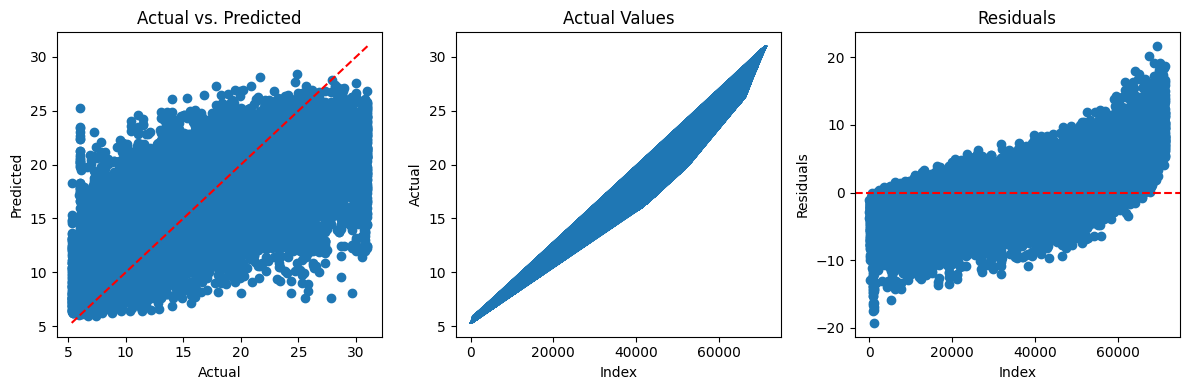

In [ ]:
residuals = comparison['Actual'] - comparison['Predicted']

# Create a figure with two subplots
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(12, 4))

# Plot actual vs. predicted values
ax1.scatter(comparison['Actual'], comparison['Predicted'])
ax1.plot([min(comparison['Actual']), max(comparison['Actual'])], [min(comparison['Actual']), max(comparison['Actual'])], 'r--')
ax1.set_xlabel('Actual')
ax1.set_ylabel('Predicted')
ax1.set_title('Actual vs. Predicted')

# Plot actual values
ax2.plot(comparison.index, comparison['Actual'])
ax2.set_xlabel('Index')
ax2.set_ylabel('Actual')
ax2.set_title('Actual Values')

# Plot residuals
ax3.scatter(comparison.index, residuals)
ax3.axhline(y=0, color='r', linestyle='--')
ax3.set_xlabel('Index')
ax3.set_ylabel('Residuals')
ax3.set_title('Residuals')

# Adjust layout and display the plot
plt.tight_layout()
plt.show()

In [ ]:
import joblib
joblib.dump(model, 'lightgbm_model.pkl')

['lightgbm_model.pkl']

## **Conclusion**

Based on the evaluation results, the Light GBM regressor performed the best among the tested models, achieving the lowest mean squared error (MSE) of 20.715 and the highest R2 score of 0.502. This indicates that the Light GBM model captured the underlying patterns in the data effectively and provided more accurate predictions compared to other models.

The pipeline, which consisted of feature extraction, preprocessing, and the Light GBM model, was trained on the training data and used to predict the target variable on the test data. The predicted values were then compared to the actual values, and a scatter plot of the actual versus predicted values was created.

The plot shows a generally positive linear relationship between the actual and predicted values, as the majority of points lie close to the diagonal line. However, there are some deviations and outliers, as indicated by the residuals plot, which shows the differences between the actual and predicted values. These deviations suggest that the model may have some room for improvement in capturing the variability in certain instances.

Overall, the Light GBM model demonstrated good performance in predicting the target variable, but further analysis and fine-tuning may be necessary to improve accuracy and reduce the residuals.